### 고양이 수염 스티커 만들기 프로젝트

* Step 1. 스티커 구하기 or 만들기
* Step 2. 얼굴 검출 & 랜드마크 검출 하기
* Step 3. 스티커 적용 위치 확인하기
* Step 4. 스티커 적용하기
* Step 5. 문제점 찾아보기

#### 진행 순서                  
    1. 여러 얼굴 이미지를 준비한다. 
    2. NODE에서 제시하는 코드를 기반으로 Class를 만든다. 
    3. 파라미터를 변경하며 테스트 해본다.
    
#### 회고
    1. 최종 결과는 8장 중 7장 성공했다.
    
    2. 아래 문제점은 추가 개선이 필요하다. 
        1. 원거리 이미지도 정확히 face detect 하기 위해서는 upsampling이 필요한데 실행 시간과 trade off 관계이다.
        1. 각도에 따라 고양이 수염도 변환이 필요하다. 
        1. 측면 얼굴에 대해서는 face detect이 잘 되지 않는다. 

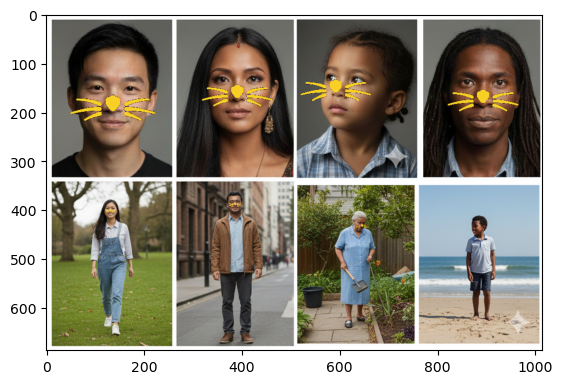

In [1]:
# 추가 설치
# !pip install cmake opencv-python
# !conda install -y dlib

In [2]:
import os
import sys
import time
from pathlib import Path

import cv2 
import numpy as np 
import dlib

import matplotlib.pyplot as plt 

##### NODE에서 제시하는 코드를 기반으로 Class를 정의한다.

In [3]:

class FaceDecorator():
    def __init__(self, debug=False):
        self.list_debug_image = []
        self.list_debug_msg = []
        self.list_landmarks = []
        pass
        
    def load_resources(self, src, mask):
        # .ipynb에서 수행 시 path 설정 
        base_path = os.getenv('HOME')
        base_path = Path(os.path.join(base_path, "work/Repo/AIFFEL_quest_eng/Computer_Vision/CV01"))

        model_path = base_path / "models" / "shape_predictor_68_face_landmarks.dat"
        src_image_path = base_path / "images" / src
        mask_image_path = base_path / "images" / mask

        # .py에서 수행 시 시 path 설정 
        # base_path = Path(__file__).resolve().parent
        # model_path = base_path / "models" / "shape_predictor_68_face_landmarks.dat"
        # src_image_path = base_path / "images" / src
        # mask_image_path = base_path / "images" / mask

        for file in [model_path, src_image_path, mask_image_path]:
            if not file.exists():
                raise FileNotFoundError(f"{file}")

        self.landmark_predictor = dlib.shape_predictor(str(model_path))
        self.image_mask_bgr = cv2.imread(mask_image_path)
        
        self.image_face_bgr = cv2.imread(src_image_path)
        self.image_face_rgb = cv2.cvtColor(self.image_face_bgr, cv2.COLOR_BGR2RGB)

        debug_msg = "origin image"
        return self.image_face_rgb, debug_msg

    def detect_face(self, upsample_num_times):
        # HOG(Histogram of Oriented Gradients) - HOG 특징점과 SVM 분류기를 조합 - 정면 얼굴에 효과적 
        detector_hog = dlib.get_frontal_face_detector() 
        
        # # detect_face 메서드 내부에서 호출 전 추가
        # img_uint8 = np.array(self.image_face_rgb, dtype=np.uint8)
        # self.dlib_rects = detector_hog(img_uint8, 1)

        self.dlib_rects = detector_hog(image=self.image_face_rgb, 
                                        upsample_num_times=upsample_num_times)

        debug_image = self.image_face_rgb.copy()

        start = time.time()
        for rect in self.dlib_rects:
            l, t, r, b = rect.left(), rect.top(), rect.right(), rect.bottom()
            cv2.rectangle(debug_image, (l, t), (r, b), (0,255,0), 2, lineType=cv2.LINE_AA)

        end = time.time()

        debug_msg = f"detect_face(): upsample no = {upsample_num_times}, elapsed time = {(end-start)*1000:.3f} ms"
        return debug_image, debug_msg

    def find_land_mark(self):
        debug_image = self.image_face_rgb.copy()

        for rect in self.dlib_rects:
            points = self.landmark_predictor(self.image_face_rgb, rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            self.list_landmarks.append(list_points)

        for landmark in self.list_landmarks:
            for point in landmark:
                 cv2.circle(debug_image, point, 2, (0, 255, 255), -1)

        debug_msg = "find_land_mark()"
        return debug_image, debug_msg
        # self.append_debug_info(debug_image, debug_msg)

    def draw_maker(self):
        for dlib_rect, landmark in zip(self.dlib_rects, self.list_landmarks):
            # 스티커 적용할 위치의 중심 좌표(target_x, target_y)를 설정하고 
            target_x = landmark[30][0]
            target_y = landmark[30][1]
            
            # 수염이 위치할 bounding_box의 크기를 구한다. 
            # 수염 bounding box의 크기는 얼굴 bounding box의 1/3정도면 자연스러워 보인다. 
            cat_bounding_box_w = dlib_rect.width()
            cat_bounding_box_h = dlib_rect.height() // 3
        
            # 스티커를 얼굴에 맞는 크기로 resize 한다.     
            image_mask_bgr = cv2.resize(self.image_mask_bgr, (cat_bounding_box_w, cat_bounding_box_h))
        
            # 수염이 위치할 rect의 left, top을 찾는다.
            mask_left_top_x = target_x - cat_bounding_box_w // 2
            mask_left_top_y = target_y - cat_bounding_box_h // 2 
        
            # 원본 영역의 일부를 따로 떼어 놓는다.
            mask_width = image_mask_bgr.shape[0]
            mask_height = image_mask_bgr.shape[1]

            image_face_bgr_mask_area = self.image_face_bgr[
                mask_left_top_y : mask_left_top_y + mask_width,  
                mask_left_top_x : mask_left_top_x + mask_height 
            ]

            # 원본 이미지 특정 영역에 스티커를 붙인다.
            # 스티커의 검은색 부분(0)은 무시하고(투명 처리) 실제 그림이 있는 부분만 덮어씌운다. 
            # 수염 그림의 픽셀이 black (0) 이면 원본을 쓰고, 아니면 수염그림을 쓴다 
            self.image_face_bgr[
                mask_left_top_y : mask_left_top_y + mask_width,  
                mask_left_top_x : mask_left_top_x + mask_height 
            ] = np.where(image_mask_bgr == 0, image_face_bgr_mask_area, image_mask_bgr).astype(np.uint8)

        debug_image = cv2.cvtColor(self.image_face_bgr, cv2.COLOR_BGR2RGB)
        debug_msg = "draw_maker()"
        return debug_image, debug_msg
        
    def append_debug_info(self, image, msg ): 
        self.list_debug_image.append(image)
        self.list_debug_msg.append(msg)

In [4]:
def show_image_msg(image, msg):
    print(msg)
    plt.imshow(image)
    plt.show()

#### 메인 객체를 생성한다.

In [5]:
s = FaceDecorator()

##### 대상 이미지, 스티커, 모델을 로드한다.

origin image


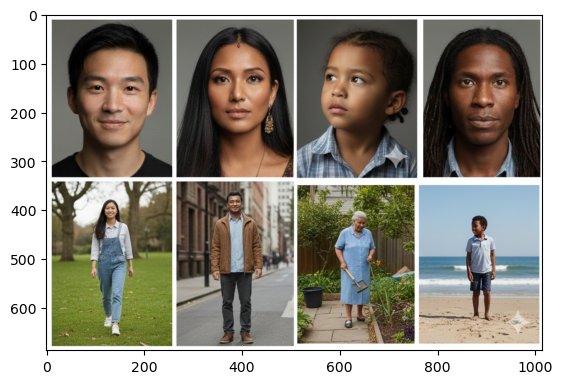

In [6]:
src = "faces.png"
mask = "cat-whiskers.png"

image, msg = s.load_resources(src, mask)
show_image_msg(image, msg)

##### 얼굴 영역을 인식한다. upsample_num_times = 1
* 8장 중 3장에서 오인식, 미인식이 발생한다.

detect_face(): upsample no = 1, elapsed time = 0.625 ms


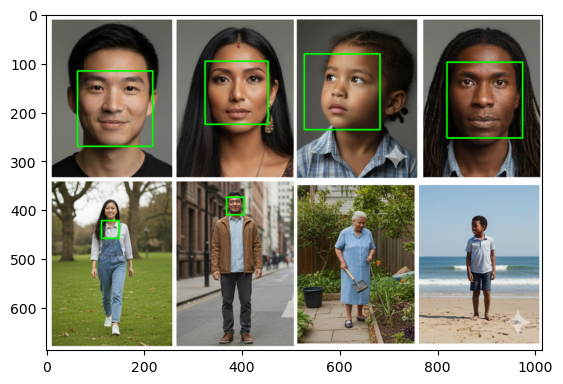

In [7]:
image, msg = s.detect_face(upsample_num_times=1)
show_image_msg(image, msg)

##### 얼굴 영역을 인식한다. * upsample_num_times = 4 
* 8장 중 1장에서 미 인식 발생한다. 성능은 좋아지지만 시간도 늘어난다.

detect_face(): upsample no = 4, elapsed time = 0.487 ms


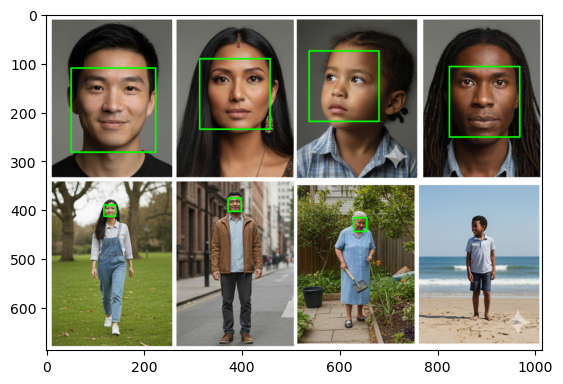

In [8]:
image, msg = s.detect_face(upsample_num_times=4)
show_image_msg(image, msg)

##### land mark를 표시한다.

find_land_mark()


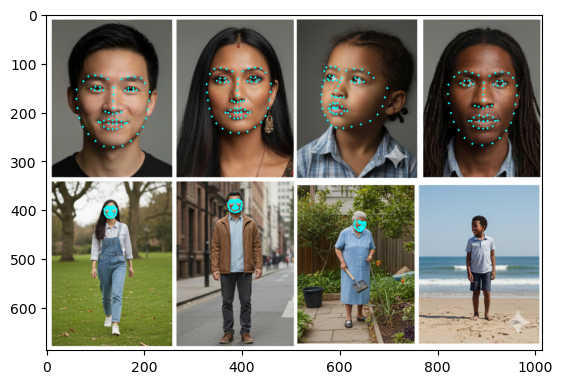

In [9]:
image, msg = s.find_land_mark()
show_image_msg(image, msg)

##### 고양이 스티커를 붙안다. 

draw_maker()


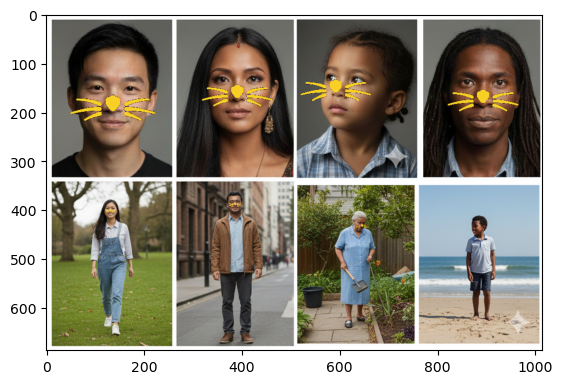

In [10]:
image, msg = s.draw_maker()
show_image_msg(image, msg)